In [1]:
## Overview 

In [1]:
### Import Libraries
#import libraries
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import decomposition
from joblib import dump, load

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report, accuracy_score 
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA

import time
import sys
sys.path.insert(0,'../../../../../utils')
from helper_functions import *
#import helper_function custom library
from model_builder import ModelBuilder
pd.options.mode.chained_assignment = None
%matplotlib inline 

In [2]:
### Import Data and Clean Data


In [3]:
#load spectra data
#import_spectra
spectra = pd.read_csv("../../../../../data/imp_bands.csv")
df_aug = pd.read_csv("../../../../../data/refCanopies0802_0630.txt")
df_sep = pd.read_csv("../../../../../data/refCanopies0917_0630.txt")
df_oct = pd.read_csv("../../../../../data/refCanopies1016_0630.txt")

#load tree data
df_tree = pd.read_csv("../../../../../data/Export_Output_2_0630.txt")

In [4]:
#select 22 bands only
cols = list(df_aug.columns[:8]) + [str(i) for i in list(spectra.imp_bands)]
df_aug = df_aug[cols]
df_sep = df_sep[cols]
df_oct = df_oct[cols]
df_aug.head()

,ROIID,IDwithROI,X,Y,MapX,MapY,Lat,Lon,440.24,441.93,...,654.07,655.8,657.52,659.24,840.32,842.04,843.76,845.49,847.21,848.93
0,1,1,6558,1881,697516.92,4522326.17,40.828198,-96.657615,0.0159,0.0153,...,0.0242,0.0240,0.0230,0.0218,0.1312,0.1315,0.1323,0.1339,0.1361,0.1384
1,1,2,6559,1881,697517.52,4522326.17,40.828198,-96.657608,0.0155,0.0157,...,0.0236,0.0231,0.0223,0.0216,0.1339,0.1349,0.1362,0.1376,0.1399,0.1424
2,1,3,6560,1881,697518.12,4522326.17,40.828198,-96.657600,0.0164,0.0163,...,0.0298,0.0287,0.0275,0.0266,0.2173,0.2209,0.2228,0.2252,0.2275,0.2292
3,1,4,6561,1881,697518.72,4522326.17,40.828198,-96.657593,0.0164,0.0163,...,0.0298,0.0287,0.0275,0.0266,0.2173,0.2209,0.2228,0.2252,0.2275,0.2292
4,1,5,6562,1881,697519.32,4522326.17,40.828197,-96.657586,0.0175,0.0177,...,0.0337,0.0332,0.0324,0.0315,0.2763,0.2779,0.2804,0.2831,0.2855,0.2875


In [5]:
#clean data
#removes non-vegatation pixels, tRef.NDVI = (tRef.x800_67 - tRef.x679_92) ./ (tRef.x800_67 + tRef.x679_92)
#removes shaded or dark pixels as well, (pixel's reflectance@800_67 <=0.15)
df_aug = data_cleaning(df_tree,df_aug)
df_sep = data_cleaning(df_tree,df_sep)
df_oct = data_cleaning(df_tree,df_oct)

In [6]:
### Merge Data and Split Data

In [7]:
#merge data
#column-wise left-join of the three datasets
#join August and September images by extracting common pixels (intersections)
df = merge_images([df_aug,df_sep,df_oct])

In [8]:
### No Dimesion Reduction

In [9]:
#split data 
#features (spectra)
X = df[df.columns[3:]].values
#predictor/target(tree species class)
y = LabelEncoder().fit_transform(df.TARGET) 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=101) #70:30 split, train-test

In [10]:
### Build A Model

In [11]:
model_name = "species_multi22_merged_nd"
merge_nd = RandomForestClassifier(n_estimators = 100,verbose=1, oob_score = True)
merge_nd.fit(X_train,y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.6min finished


RandomForestClassifier(oob_score=True, verbose=1)

In [12]:
labels = ['Sugar Maple', "Eastern Redbud", "Green Ash", 'Norway Spruce','Austrian Pine','Ponderosa Pine',
          'Colorado Spruce', 'Scotch Pine','White Oak','Bur Oak', 'Red Oak']
nclasses = 11
evals = []

In [13]:
#save the model
save_model(merge_nd,model_name)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    4.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.7s finished


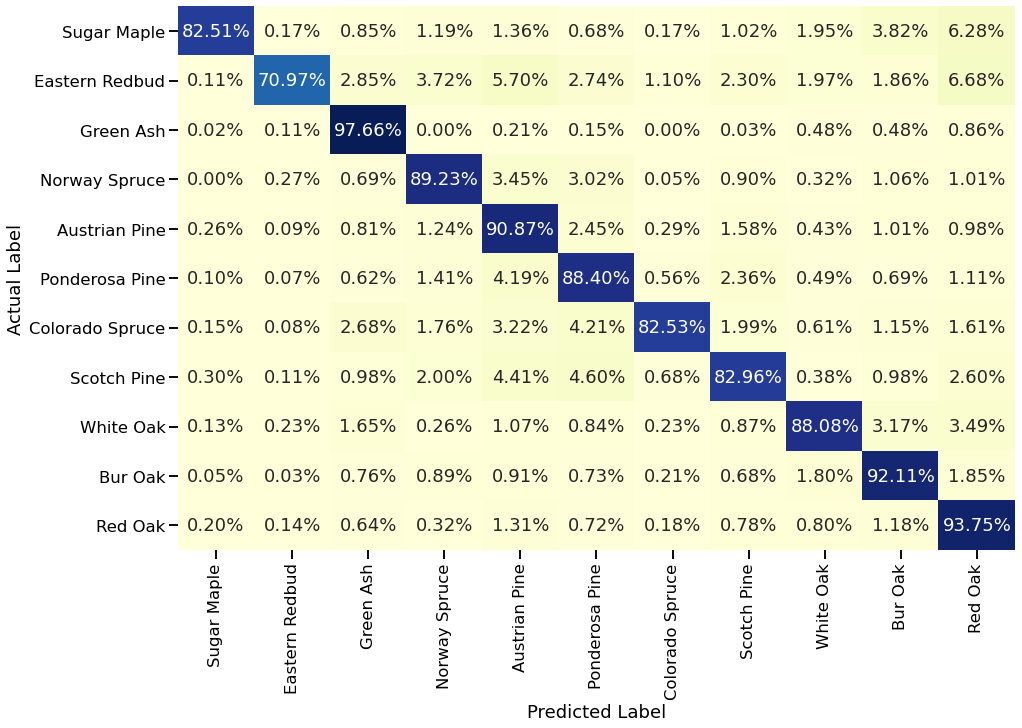

In [14]:
#metrics
train_preds = merge_nd.predict(X_train)
preds = merge_nd.predict(X_test)
train_accuracy = 100*(accuracy_score(train_preds,y_train))
test_accuracy = 100*(accuracy_score(y_test, preds))
generate_cf(model_name,y_test,preds,nclasses,labels)
merge_nd_results =pd.DataFrame.from_dict( {"Model":[model_name], "Train Accuracy(%)":[train_accuracy],
        "Test Accuracy(%)":[test_accuracy]})
evals.append(merge_nd_results)

In [15]:
#complile results
df_results = pd.concat(evals)
df_results

,Model,Train Accuracy(%),Test Accuracy(%)
0,species_multi22_merged_nd,99.929031,90.322284


In [16]:
df_results.to_csv('species_multi22_merged_summary_results.csv')